Zachary Armand

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
# Use for creating and saving tensors at end of process
from torch import save, tensor
from torch.nn.utils.rnn import pad_sequence

In [51]:
#pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Data Preprocessing

In [28]:
def delete_unique_at_bats(df, ind):
    """
        For a given dataframe and index, delete all pitches in that at-bat sequence.
        At-bat sequences are determined by pitches that share game date, at-bat number, and home team.
    """

    # Get game date, at bat number, and home team from this index as a list
    at_bat_info = df.loc[ind][['game_date', 'at_bat_number', 'home_team']].values.tolist()

    if isinstance(ind, (list, pd.core.indexes.base.Index, np.ndarray)):  # mulitple indices to delete
        # Create a mask to match the rows
        mask = df.apply(lambda row: [row['game_date'], row['at_bat_number'], row['home_team']] in at_bat_info, axis=1)
        # Get indices here
        all_inds = mask.index[mask]
    else:   # single index
        # Get indices of rows with these values
        all_inds = df[(df['game_date'] == at_bat_info[0]) & (df['at_bat_number'] == at_bat_info[1]) & (df['home_team'] == at_bat_info[2])].index

    # Delete these indices
    df_cleaned = df.drop(index=all_inds, inplace=False)

    return df_cleaned

## Load data
Load the 2024 Statcast data and pitch clustering data from a CSV. Of course, make sure that you have the full 2024 data csv in your local directory.

In [29]:
statcast_2024 = pd.read_csv('../2024pitches.csv')
pitch_clusters = pd.read_csv("../pitch_clusters.csv")

### Basic Filtering
A lot of this filtering and clustering was done by Zach B.

- Regular season games
- Score difference < 6
- Remove pitches with < 3 appearances

In [30]:
# Regular season games only
statcast_df = statcast_2024[statcast_2024['game_type'] == 'R']

# Score difference < 6
statcast_df = statcast_df[abs(statcast_df['home_score_diff']) < 6]

# Identify pitchers with < 3 appearances
pitcher_appearances = statcast_df.groupby(['pitcher', 'game_date']).size()
pitcher_games = pitcher_appearances.groupby('pitcher').size()
pitchers_with_few_games = pitcher_games[pitcher_games < 3].index
# Filter out those pitchers
statcast_df = statcast_df[~statcast_df['pitcher'].isin(pitchers_with_few_games)]

In [31]:
# Binary encoding (batter and pitcher handedness)
statcast_df['stand'] = statcast_df['stand'].replace({'L': 0, 'R': 1})
statcast_df['p_throws'] = statcast_df['p_throws'].replace({'L': 0, 'R': 1})

/var/folders/s0/8ys2gvm954l0zln605l0tpwr0000gn/T/ipykernel_31162/4027873161.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  statcast_df['stand'] = statcast_df['stand'].replace({'L': 0, 'R': 1})
/var/folders/s0/8ys2gvm954l0zln605l0tpwr0000gn/T/ipykernel_31162/4027873161.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  statcast_df['p_throws'] = statcast_df['p_throws'].replace({'L': 0, 'R': 1})


In [32]:
# Grab first set of columns of interest and filter
columns = [
    "pitch_type", "release_speed", "release_pos_x", "release_pos_z", "batter", "pitcher", "events", "description", "zone", "des",
    "game_type", "stand", "p_throws", "type", "balls", "strikes", "pfx_x", "pfx_z", "plate_x", "plate_z", "on_3b", "on_2b", "on_1b",
    "hc_x", "hc_y", "sv_id", "vx0", "vy0", "vz0", "ax", "ay", "az", "sz_top", "sz_bot", "hit_distance_sc", "launch_speed",
    "launch_angle", "effective_speed", "release_spin_rate", "release_extension", "game_pk", "release_pos_y",
    "estimated_woba_using_speedangle", "launch_speed_angle", "at_bat_number", "pitch_number", "pitch_name", "home_score",
    "away_score", "spin_axis", "delta_home_win_exp", "delta_run_exp", "bat_speed", "swing_length",
    "estimated_slg_using_speedangle", "delta_pitcher_run_exp", "bat_win_exp", "n_thruorder_pitcher",
    "n_priorpa_thisgame_player_at_bat", "arm_angle",
    'game_date', 'home_team']

statcast_df = statcast_df[columns]

### Pitch Clustering

In [33]:
# Add pitch cluster data
pitch_clusters_long = pitch_clusters.melt(id_vars=['pitcher'], var_name='pitch_type', value_name='cluster_label')
pitch_clusters_long = pitch_clusters_long[pitch_clusters_long['cluster_label'] != -1]
pitch_data = statcast_df.merge(pitch_clusters_long, on=['pitcher', 'pitch_type'], how='left')

In [34]:
# Add zone data
x_bins = np.linspace(-2, 2, num=3)  #Binning plate_x from -2 to 2 into 4 bins
z_bins = np.linspace(0, 4, num=3)   #Binning plate_z from 0 to 4 into 4 bins

# Assign pitches to zones based on plate_x and plate_z
pitch_data['zone_x'] = np.digitize(pitch_data['plate_x'], bins=x_bins, right=False)
pitch_data['zone_z'] = np.digitize(pitch_data['plate_z'], bins=z_bins, right=False)

#single zone identifier
pitch_data['zone'] = pitch_data['zone_x'].astype(str) + '-' + pitch_data['zone_z'].astype(str)
zone_xwoba = pitch_data.groupby(['batter', 'pitch_type', 'zone'])['estimated_woba_using_speedangle'].mean().reset_index()

pitch_data = pitch_data.merge(zone_xwoba, on=['batter', 'pitch_type', 'zone'], suffixes=('', '_zone_avg'))
print("Number of pitches:", pitch_data.shape[0])

Number of pitches: 641074


### NA removal

Removing rows and at-bats where pitch_type, release_speed, spin_axis, release_extension, and effective_speed have NA values. I made sure to remove entire at-bat sequences.

In [35]:
# Filter down to just the relevant columns (features + target)
cols = ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'effective_speed', 'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'cluster_label', 'n_thruorder_pitcher',
            'game_date', 'at_bat_number', 'home_team', 'estimated_woba_using_speedangle', 'description', 'launch_angle']

pitch_data_filtered = pitch_data[cols]

In [36]:
# Get indices of na values for select columns
nas = pitch_data_filtered[pitch_data_filtered[['pitch_type', 'release_speed', 'spin_axis', 'release_extension',
                             'effective_speed', 'cluster_label', 'estimated_woba_using_speedangle_zone_avg']].isna().any(axis=1)].index

# Clean dataset of these na values. This is the longest step.
pitch_data_cleaned_filtered = delete_unique_at_bats(pitch_data_filtered, nas)

print("Number of pitches:", pitch_data_cleaned_filtered.shape[0])

Number of pitches: 485905


### Group into unique at bats
Group pitches into a dataframe of unique at-bats. Grouped by gate date, at bat number, and home team

In [37]:
# Group by the specified columns
grouped = pitch_data_cleaned_filtered.groupby(['game_date', 'at_bat_number', 'home_team'])
# First row in each pitch frame is the last pitch in the sequence - note that there's a value for wOBA
grouped.first()

pitch_type  release_speed  release_pos_x  \
game_date  at_bat_number home_team                                            
2024-03-20 2             SD                FS           91.1          -2.05   
           3             SD                SI           95.4          -2.11   
           4             SD                FF           94.5          -1.91   
           6             SD                FF           96.6          -1.69   
           10            SD                FF           94.0          -2.11   
...                                       ...            ...            ...   
2024-09-30 76            ATL               CU           86.4          -2.31   
           77            ATL               FF           95.2          -2.12   
           79            ATL               FF           94.2          -2.16   
           81            ATL               SL           91.0          -2.00   
           82            ATL               FF           97.4          -2.10   

                                    release_pos_z  pfx_x  pfx_z  plate_x  \
game_date  at_bat_number home_team                                         
2024-03-20 2             SD                  5.58  -1.33   0.22    -0.80   
           3             SD                  5.61  -1.51   0.56     0.33   
           4             SD                  5.67  -0.35   1.62    -0.07   
           6             SD                  6.17  -0.02   1.30    -0.03   
           10            SD                  5.72  -0.47   1.42     0.04   
...                                           ...    ...    ...      ...   
2024-09-30 76            ATL                 6.04   0.84  -0.19     0.15   
           77            ATL                 6.13  -0.94   1.21     0.20   
           79            ATL                 4.93  -1.11   1.20     0.84   
           81            ATL                 5.21   0.26   0.62     1.25   
           82            ATL                 4.88  -0.96   0.99     0.67   

                                    plate_z  spin_axis  effective_speed  \
game_date  at_bat_number home_team                                        
2024-03-20 2             SD            2.82      264.0             90.1   
           3             SD            2.22      253.0             94.1   
           4             SD            2.37      193.0             93.4   
           6             SD            3.69      181.0             98.0   
           10            SD            3.46      200.0             92.5   
...                                     ...        ...              ...   
2024-09-30 76            ATL           1.72       36.0             86.2   
           77            ATL           3.55      222.0             94.9   
           79            ATL           2.93      233.0             96.5   
           81            ATL           2.22      204.0             93.2   
           82            ATL           3.00      232.0             99.9   

                                    release_extension  \
game_date  at_bat_number home_team                      
2024-03-20 2             SD                       5.8   
           3             SD                       6.0   
           4             SD                       6.2   
           6             SD                       7.4   
           10            SD                       5.9   
...                                               ...   
2024-09-30 76            ATL                      5.9   
           77            ATL                      6.0   
           79            ATL                      7.5   
           81            ATL                      7.4   
           82            ATL                      7.6   

                                    estimated_woba_using_speedangle_zone_avg  \
game_date  at_bat_number home_team                                             
2024-03-20 2             SD                                         0.590800   
           3             SD                                 

Remove groups that don't have any rows with a value for estimated woba using speedangle or a value of 'hit_into_play' for 'description'. Basically, if there's any at-bats where a ball was not hit into play.

In [38]:
# Removing groups where none of the rows have a estimated woba using speedangle
filtered_grouped = grouped.filter(lambda group: group['estimated_woba_using_speedangle'].notna().any())
grouped = filtered_grouped.groupby(['game_date', 'at_bat_number', 'home_team'])

# Removing groups where none of the rows have 'hit_into_play' in 'description' column
filtered_grouped = grouped.filter(lambda group: (group['description'] == 'hit_into_play').any())
grouped = filtered_grouped.groupby(['game_date', 'at_bat_number', 'home_team'])

Notice that all of the below (last pitch in sequence) now have a description of 'hit_into_play'.

In [39]:
grouped.first()['description']

game_date   at_bat_number  home_team
2024-03-20  2              SD           hit_into_play
            4              SD           hit_into_play
            6              SD           hit_into_play
            10             SD           hit_into_play
            11             SD           hit_into_play
                                            ...      
2024-09-30  75             ATL          hit_into_play
            76             ATL          hit_into_play
            77             ATL          hit_into_play
            79             ATL          hit_into_play
            82             ATL          hit_into_play
Name: description, Length: 93419, dtype: object

### Sequence clipping

I want to make mimize one or two very long sequences causing us to increase the size of our time series dataframe dramatically. So, will clip the top 1% of length outliers (which at time of writing means clipping any time series with more than 8 pitches)

In [40]:
# Figure out how many pitches each at bat has
sizes = grouped.size().values
max_pitches = np.quantile(sizes, 0.99)
print(f"Include seqeunces with less than {int(max_pitches) + 1} pitches.")
# Drop groups with these
filtered_grouped = grouped.filter(lambda x: len(x) <= max_pitches)
grouped = filtered_grouped.groupby(['game_date', 'at_bat_number', 'home_team'])

Include seqeunces with less than 9 pitches.


In [41]:
print("Number of unique pitch sequences: ", len(grouped))

Number of unique pitch sequences:  92526


### Finalize predictors and targets

In [42]:
# Determine variables of interest
features = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg',
            'cluster_label', 'n_thruorder_pitcher']
target = 'estimated_woba_using_speedangle'

In [43]:
# Get last pitches in sequence (first in series) and convert to numpy array. These contain the wOBA values
ys = grouped.first()[target].to_numpy(dtype='float32')

In [44]:
# Filter variables down
grouped_features = grouped[features]
# Get features into one array
input_values = np.array(np.array([g[1].to_numpy(dtype='float32') for g in grouped_features], dtype="object"), dtype="object")
# Scale each
n_variables = len(features)

In [45]:
print("Number of pitch sequences:", ys.shape[0])
print("Number of variables:", input_values[0].shape[1])

Number of pitch sequences: 92526
Number of variables: 12


### Scale variables 
Scale using zero mean scaling. Get mean, var of column across all time steps, and scale accordingly.

In [46]:
'''
# List to store the numpy arrays for each column within each group
variables_list = [[] for _ in range(12)]
scalers = [(0, 1)] * 12  # [mean, var] intialized to (0, 1)

# For each data series
for series in tqdm(input_values):
  # For each column in that series
  for i in range(12):
    # Add values to running list
    variables_list[i].extend(series[:, i].flatten())

# Determine the mean and variance of that column's array
for i, series in enumerate(variables_list):
  series = np.array(series)
  mean, var = series.mean(), series.std()
  scalers[i] = (mean, var)
'''

"\n# List to store the numpy arrays for each column within each group\nvariables_list = [[] for _ in range(12)]\nscalers = [(0, 1)] * 12  # [mean, var] intialized to (0, 1)\n\n# For each data series\nfor series in tqdm(input_values):\n  # For each column in that series\n  for i in range(12):\n    # Add values to running list\n    variables_list[i].extend(series[:, i].flatten())\n\n# Determine the mean and variance of that column's array\nfor i, series in enumerate(variables_list):\n  series = np.array(series)\n  mean, var = series.mean(), series.std()\n  scalers[i] = (mean, var)\n"

In [47]:

scaled_input_values = deepcopy(input_values)
'''
# Transform the values using these means/vars
for j in range(len(scaled_input_values)):
  for i, scaler in enumerate(scalers):
    series = scaled_input_values[j]
    series[:, i] = (series[:, i] - scaler[0] ) / scaler[1]
'''

'\n# Transform the values using these means/vars\nfor j in range(len(scaled_input_values)):\n  for i, scaler in enumerate(scalers):\n    series = scaled_input_values[j]\n    series[:, i] = (series[:, i] - scaler[0] ) / scaler[1]\n'

In [48]:
print(scaled_input_values[0][0])
print(input_values[0][0])

[ 9.110e+01 -2.050e+00  5.580e+00 -1.330e+00  2.200e-01 -8.000e-01
  2.820e+00  2.640e+02  5.800e+00  5.908e-01  0.000e+00  1.000e+00]
[ 9.110e+01 -2.050e+00  5.580e+00 -1.330e+00  2.200e-01 -8.000e-01
  2.820e+00  2.640e+02  5.800e+00  5.908e-01  0.000e+00  1.000e+00]


### Target value distribution

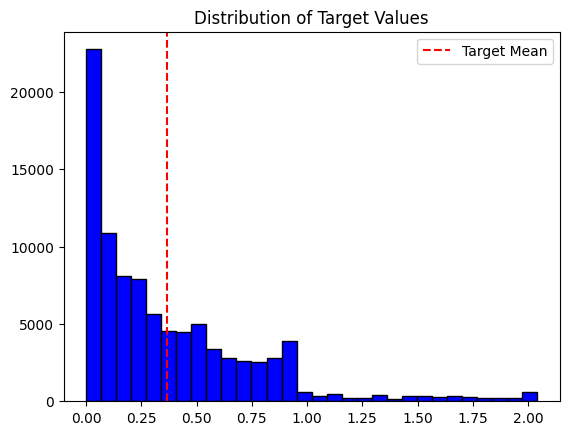

In [49]:
# Plot the values
plt.title("Distribution of Target Values")
plt.hist(ys, bins=30, color='b', edgecolor='black')
plt.axvline(x=ys.mean(), color='r', linestyle='--', label='Target Mean')
plt.legend()
plt.show()

### Save input and target tensors for disk for future use

In [ ]:
# Convert the list of numpy arrays to a list of tensors
input_tensor = [tensor(series) for series in scaled_input_values]
# Pad sequences to have consistent length across all time series - (B, max_sequence_length, variables)
input_tensor = pad_sequence(input_tensor, batch_first=True, padding_value=0.0)
target_vals = tensor(ys)

# Example usage
#MLP_dataset = TensorDataset(input_tensor, target_vals)

# Save input and target tensors
save(input_tensor, 'input_values.pth')  # torch.save
save(target_vals, 'target_values.pth')  # torch.save